# Change in labor capacity associated with wet bulb temperature


- Calculate WBT, WBGT for current and climatology
- Calculate labour capacity
- Project to RURAL population


The labour capacity in percent (%) at a given location as a function of Wet Bulb Globe Temperature (WBGT) is

$$
labour\;capacity = 100 - 25* \max(0, WBGT - 25)^{2/3}
$$

Note that this number MUST be > 0, and could equally be defined as


$$
labour\;capacity = \max(0, 100 - 25* \max(0, WBGT - 25)^{2/3})
$$


The global capacity is then defined as:

$$
global\;capacity(t) =  \frac{ \int labour\;capacity(x,t) * P(x,t)dx }{\int P(x,t) }
$$

Where P is restricted to the rural population. This gives a scalar value for each year. To quantify where and how much of the global labour capacity is being lost at each location x, the lost labour is defined locally as :

$$
lost\;labour( x , t ) = \frac{( 100 − labour\;capacity( x , t ) ) ∗ P ( x , t )}{\bar P(t) }
$$


In [1]:
%matplotlib inline

from pathlib import Path
from datetime import date

import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd 
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from scipy import stats
from tqdm import tnrange, tqdm_notebook

from config import DATA_SRC,POP_DATA_SRC , ERA_MONTHLY_FILE, CLIMATOLOGY_FILE_RESAMP, SHAPEFILES_SRC
import weather_ecmwf
import util
import config

import climate_conversions
import population_tools

def calculate_labour_capacity(wbgt):
    """NOTE: wbgt in Kelvin so have to adjust original formula"""
    labourcapacity = np.maximum(100 - 25 * np.power(np.maximum(wbgt - 273.15 - 25 , 0), (2/3)), 0)
    return labourcapacity

## Plot the labour capacity function

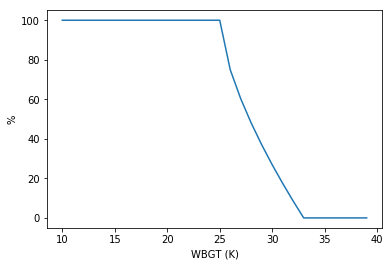

In [2]:
_wbgt = np.arange(10, 40, 1)
labourcapacity = np.maximum(0, 100 - 25 * np.power(np.maximum(_wbgt - 25 , 0), (2/3)))
plt.plot(_wbgt, labourcapacity)
plt.xlabel('WBGT (K)')
plt.ylabel('%')

## Load urban/rural population ratio and associate with country shapes


In [3]:
UN_DEMOGRAPHICS_TABLE = pd.read_csv(POP_DATA_SRC / 'UN' / 'urban_pop_percentage.csv', index_col='Country Code')
UN_DEMOGRAPHICS_TABLE = UN_DEMOGRAPHICS_TABLE.drop(['Index', 'Major area, region, country or area', 'Note'], axis=1)

country_shapefile = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

# COUNTRY_POLY_SHP
COUNTRIES = gpd.read_file(str(country_shapefile))
# Translate to match raster coordinates
COUNTRIES.geometry = COUNTRIES.translate(xoff=180)

# Remove missing UN A3 code fields, convert to int and set as index
COUNTRIES.loc[COUNTRIES.un_a3 == '-099', 'un_a3'] = np.nan
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(float)
COUNTRIES = COUNTRIES[np.isfinite(COUNTRIES.un_a3)]
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(int)
COUNTRIES = COUNTRIES.set_index('un_a3')


In [4]:
def get_country_demographics_for_year(year):
    base= 5
    closest_year = int(base * round(float(year)/base))

    rural = 100 - UN_DEMOGRAPHICS_TABLE[f'{closest_year}']
    rural /= 100
    countries = COUNTRIES.copy()
    countries['pct_rural'] = rural
    return countries

In [6]:
pct_rural_rasters = []
with population_tools.PopulationProjector() as pop:
    for year in tnrange(2000, 2017):
        countries = get_country_demographics_for_year(year)
        raster = pop.rasterize_data(countries, 'pct_rural')
        raster*= pop.water_mask.squeeze()
        raster /= 100
        raster.shape = (*raster.shape, 1)
        pct_rural_rasters.append(xr.DataArray(raster, 
                                        coords=[pop.data.latitude, pop.data.longitude, [year]], 
                                        dims=['latitude', 'longitude', 'year'], name='pct_rural'))
        
pct_rural_rasters = xr.concat(pct_rural_rasters, dim='year')

Widget Javascript not detected.  It may not be installed or enabled properly.


In [7]:
pct_rural_rasters.to_netcdf(str(DATA_SRC / 'lancet' / 'population_rural.nc'))

In [5]:
pct_rural_rasters = xr.open_dataarray(str(DATA_SRC / 'lancet' / 'population_rural.nc'))

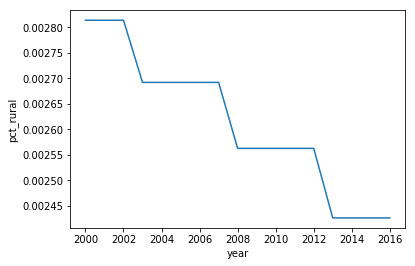

In [5]:
pct_rural_rasters.mean(dim=['latitude', 'longitude']).plot()

### Load ERA weather and Calculate relative humidity, wbt, wbgt

In [6]:
def get_wbgt():
    era_weather = weather_ecmwf.weather_dataset(ERA_MONTHLY_FILE)
#     era_weather = era_weather.sel(time=slice('2000','2016'))
    era_weather.load()
    era_weather['relative_humidity'] = climate_conversions.calculate_relative_humidity(era_weather.temperature_2m, 
                                                                                       era_weather.temperature_dewpoint)
    era_weather['wbt'] = climate_conversions.calculate_wbt(era_weather.temperature_2m, 
                                      era_weather.relative_humidity, 
                                      era_weather.surface_pressure)
    era_weather['wbgt'] = climate_conversions.calculate_wbgt(era_weather.temperature_2m, 
                                      era_weather.relative_humidity, 
                                      era_weather.surface_pressure)
    
    return era_weather['wbgt']


### Extract JJA/DJF summer months

In [7]:
def get_summer_wbgt():
    weather = get_wbgt()
    # northern hemisphere
    lat_north = weather.latitude[weather.latitude >= 0]
    lat_south = weather.latitude[weather.latitude < 0]

    # Summer North
    summer_jja = weather.time[weather['time.season'] == 'JJA']


    # Summer South
    summer_djf = weather.time[weather['time.season'] == 'DJF']



    nh = weather.sel(time=summer_jja).groupby('time.year').mean(dim='time')
    sh = weather.sel(time=summer_djf).groupby('time.year').mean(dim='time')
    wgbt_summer = xr.concat([nh.sel(latitude=lat_north),  
                             sh.sel(latitude=lat_south)], dim='latitude')
    return wbgt_summer
    
wgbt_summer = get_summer_wbgt()

In [ ]:
wgbt_summer.to_netcdf(str(DATA_SRC /'lancet' / 'summer_wbgt.nc'))

In [8]:
wgbt_summer = xr.open_dataarray(str(DATA_SRC / 'lancet' / 'summer_wbgt.nc'))

## Plot a global map of the change in summer mean WBGT relative to historical

In [9]:
historical = wgbt_summer.sel(year= slice(1986, 2008)).mean(dim='year')
current = wgbt_summer.sel(year=slice(2000, 2016))

wbgt_change = current - historical.squeeze()

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


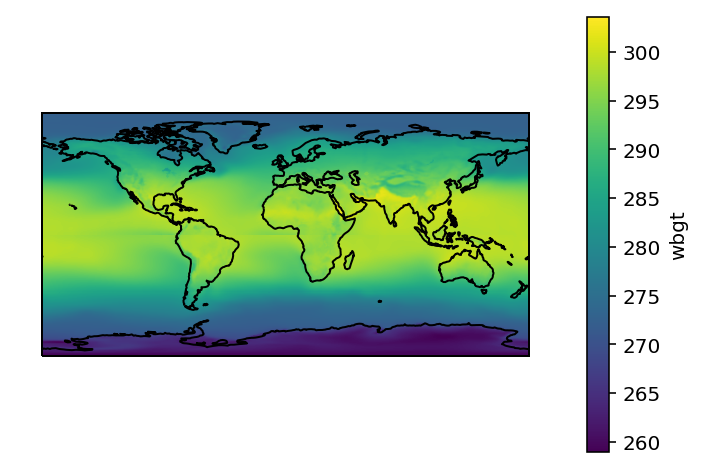

In [9]:
ax = plt.axes(projection=crs.PlateCarree())
historical.plot(ax=ax, transform=crs.PlateCarree())
ax.coastlines();

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


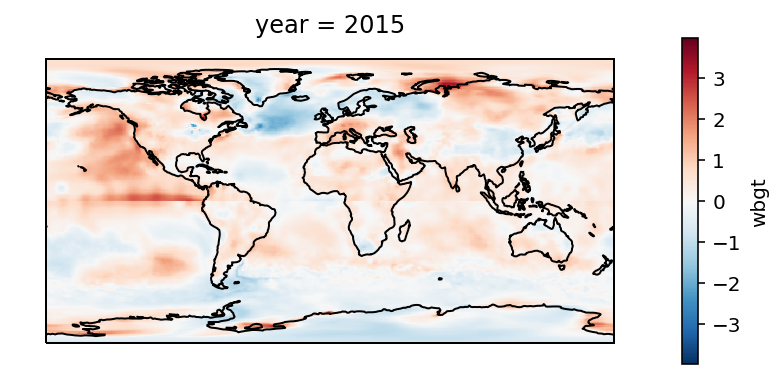

In [28]:
f = plt.figure()
ax = plt.axes(projection=crs.PlateCarree())
wbgt_change.sel(year=2015).plot(ax=ax, transform=crs.PlateCarree())
ax.coastlines()
f.set_size_inches(6.5,3)



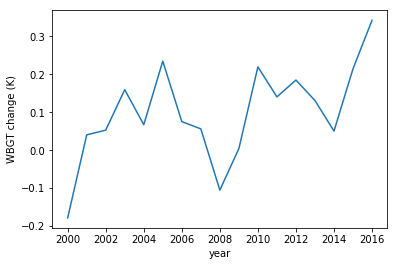

In [38]:
wbgt_change.mean(dim=['latitude', 'longitude']).plot()
plt.ylabel('WBGT change (K)')
plt.savefig('wbgt_change.png', bbox_inches='tight')

## Calculate global labour capacity change relative 1986-2008 reference period

In [35]:
labour_capacity = calculate_labour_capacity(wgbt_summer)
labour_capacity_historical = labour_capacity.sel(year=slice(1986, 2008)).mean(dim='year')
labour_delta = labour_capacity.sel(year=slice(2000, 2016)) - labour_capacity_historical

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in maximum


In [19]:
labour_delta.to_netcdf('labour_capacity_delta.nc')

In [10]:
labour_delta = xr.open_dataarray('labour_capacity_delta.nc')

### Get the area mean of the labour capacity

In [11]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(labour_delta.latitude))
labour_capacity_ts = (labour_delta.sel(year=slice(2000,2016))).mean(dim=['latitude', 'longitude'])

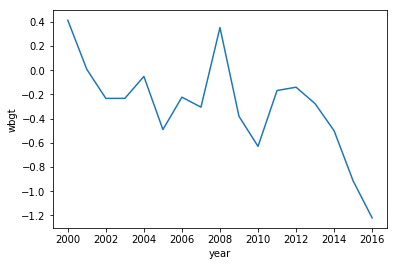

In [44]:
labour_capacity_ts.plot()

In [16]:
labour_capacity_ts.name = 'labour_capacity'
labour_capacity_ts.to_netcdf(str(DATA_SRC /'lancet' / 'labour_capacity_ts.nc'))

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


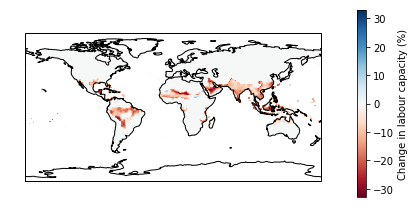

In [10]:

year_data = labour_delta.sel(year=2016) - labour_delta.sel(year=2000)
year_data = year_data * population_tools.get_water_mask(year_data)
f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=ccrs.PlateCarree())
year_data.plot.pcolormesh(ax=ax,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs=dict(label='Change in labour capacity (%)'),
                          cmap='RdBu'
                         )
ax.coastlines()
plt.tight_layout()
# plt.title('Change in Labour capacity loss 2000 to 2016')


f.savefig('labour_capacity_delta_change_2000-2016.png', dpi=300)
f.savefig('labour_capacity_delta_change_2000-2016.pdf')

## Project to the rural population

In [8]:
def get_global_capacity(labour_capacity):

    with population_tools.PopulationProjector() as pop:
        rural_pop_sum = (pop.data * pct_rural_rasters).sum(dim=['latitude', 'longitude'])
            
        def _gen():
            for year in tnrange(2000,2017):
                yield pop.project(year, labour_capacity.sel(year=year)) * pct_rural_rasters.sel(year=year)
                
        global_capacity = xr.concat(_gen(), dim='year')

        global_capacity_ts = global_capacity.sum(dim=['latitude', 'longitude']) / rural_pop_sum
        global_capacity_ts.name = 'labour_capacity'
    return global_capacity_ts.compute()

global_capacity_ts = get_global_capacity(labour_delta)

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2544: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


In [9]:
global_capacity_ts.name = 'labour_capacity'
global_capacity_ts.to_netcdf(str(DATA_SRC/'lancet'/'labour_capacity.nc'))

In [17]:
global_capacity_ts = xr.open_dataarray(str(DATA_SRC/'lancet'/'labour_capacity.nc'))


In [6]:
global_capacity_ts.to_dataframe(name='labour_capacity_change').to_csv('global_labour_capacity_change.csv')

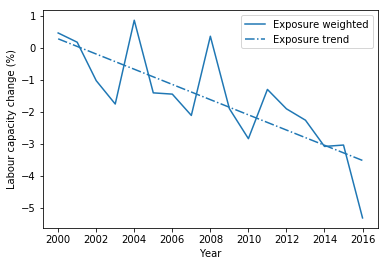

In [13]:
# labour_capacity_ts.plot(color='C1',label='Area weighted')
global_capacity_ts.plot(color='C0',label='Exposure weighted')
# mean_exposures_ts.plot(color='C9', label='Experienced, Year 2000 baseline')


# anom_reg = stats.linregress(labour_capacity_ts.year.values, labour_capacity_ts.values)
# anom_reg = (anom_reg.slope * labour_capacity_ts.year) + anom_reg.intercept

exposures_reg = stats.linregress(global_capacity_ts.year.values, global_capacity_ts.values)
exposures_reg = (exposures_reg.slope * global_capacity_ts.year) + exposures_reg.intercept

# anom_reg.plot.line('--', color='C1', label='Global trend')
exposures_reg.plot.line('-.', color='C0', label='Exposure trend')


plt.xlabel('Year')
plt.ylabel('Labour capacity change (%)')
plt.legend()
plt.savefig('labour_capacity_comp_2000-2016.png', dpi=300)
plt.savefig('labour_capacity_comp_2000-2016.pdf')





In [42]:
output = labour_capacity_ts.to_dataframe().join(global_capacity_ts.to_dataframe())
output.columns = ['Area weighted % change', 'Exposure weighted % change']

output.to_excel(str(DATA_SRC / 'lancet' / 'labour_capacity.xlsx'), sheet_name='labour_capacity_change')


## Calculate lost labour

This is for the map view

In [43]:
def get_lost_capacity():
    years = list(range(2000,2016))

    with population_tools.PopulationProjector(population_tools.PopulationType.density.value) as pop:
        rural_pct_raster = pop.rasterize_data(countries, 'pct_rural')
        rural_pct_raster.shape = (*rural_pct_raster.shape, 1)
        rural_pop_mean = (pop.data.population * rural_pct_raster).mean(dim=['latitude', 'longitude'])
        rural_pop_sum = (pop.data.population * rural_pct_raster).sum(dim=['latitude', 'longitude'])


        def _gen():
            for year in years:
                print(year)
                yield pop.project(year, 100 - labour_capacity.sel(year=year))
        print('To DataArray')
        lost_capacity = xr.concat(_gen(), dim='time')

        lost_capacity = (lost_capacity * rural_pct_raster) / rural_pop_mean
        return lost_capacity.compute()

lost_capacity = get_lost_capacity()

To DataArray
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:476: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2544: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


In [46]:
lost_capacity.to_netcdf(str(DATA_SRC / 'lancet' / 'labour_capacity_loss_pop.nc'))

## Calculate lost labour in terms of equivalent number of people removed

In [45]:
def get_global_capacity(labour_capacity):

    with population_tools.PopulationProjector() as pop:
        rural_pop_sum = (pop.data * pct_rural_rasters).sum(dim=['latitude', 'longitude'])
            
        def _gen():
            for year in tnrange(2000,2017):
                yield pop.project(year, labour_capacity.sel(year=year)) * pct_rural_rasters.sel(year=year)
                
        global_capacity = xr.concat(_gen(), dim='year')

        global_capacity_ts = global_capacity.sum(dim=['latitude', 'longitude']) / rural_pop_sum
        global_capacity_ts.name = 'labour_capacity'
    return global_capacity_ts.compute()



In [51]:
def get_lost_population(labour_anom):

    with population_tools.PopulationProjector() as pop:
        rural_pop_sum = (pop.data * pct_rural_rasters).sum(dim=['latitude', 'longitude'])
            
        def _gen():
            for year in tnrange(2000,2017):
                yield pop.project(year, labour_anom.sel(year=year)) * pct_rural_rasters.sel(year=year)
                
        global_capacity = xr.concat(_gen(), dim='year')

        global_capacity_ts = global_capacity.sum(dim=['latitude', 'longitude'])
        global_capacity_ts.name = 'labour_capacity'
    return global_capacity_ts.compute()


In [52]:
labour_delta_frac = (labour_delta / 100).copy()

In [53]:
lost_capacity_ts = get_lost_population(labour_delta_frac)

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2403: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


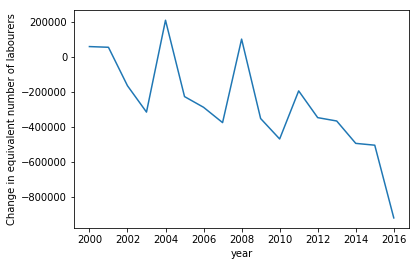

In [61]:
lost_capacity_ts.plot()
plt.ylabel('''Change in equivalent number of labourers''')

plt.savefig(str(COUNTRY_BRIEFS / 'labour_capacity' /'labourer_number_change.png'), bbox_inches='tight')

In [58]:
COUNTRY_BRIEFS = Path('./country_briefs')
lost_capacity_ts.to_dataframe().to_csv(COUNTRY_BRIEFS / 'labour_capacity' /'labourer_number_change.csv')